In [19]:
import glob
from skimage.io import imread, imsave
import skimage.draw
import matplotlib.pyplot as plt
import pandas as pd

from xml_to_dict import XMLtoDict

In [ ]:
import os.path

if not os.path.isdir('data/stones/stone_1'):
    os.mkdir('data/stones/stone_1'):

if not os.path.isdir('data/stones/stone_2'):
    os.mkdir('data/stones/stone_2'):

for voc_file in glob.glob('data/labelled/*.xml'):
    jpg_file = voc_file.replace('.xml', '.jpg')
    img = imread(jpg_file)

    stones = [
        (stone['name'], {
            'x1': int(stone['bndbox']['xmin']),
            'y1': int(stone['bndbox']['ymin']),
            'x2': int(stone['bndbox']['xmax']),
            'y2': int(stone['bndbox']['ymax']),
        })
        for stone in XMLtoDict.parse(open(voc_file).read())['annotation']['object']
    ]
    # print(stones)
    for stone_name, stone_box in stones:
        width = stone_box['x2']-stone_box['x1']
        height = stone_box['y2']-stone_box['y1']
        stone_jpg = f"data/stones/{stone_name}/{jpg_file.split('/')[-1].replace('.jpg', '')}-w{'%03d' % width}-h{'%03d' % height}-{'%04d' % stone_box['x1']}-{'%04d' % stone_box['y1']}-{'%04d' % stone_box['x2']}-{'%04d' % stone_box['y2']}.jpg"
        if not os.path.isfile(stone_jpg):
            stone_img = skimage.util.crop(img, [
                (stone_box['y1'],len(img)-stone_box['y2']),
                (stone_box['x1'],len(img[0])-stone_box['x2']),
                (0,0)
            ], copy=True)
            # fig, ax = plt.subplots(figsize=(2, 2))
            # ax.axis("off")
            # ax.imshow(stone_img)
            # plt.show()
            imsave(stone_jpg, stone_img)  

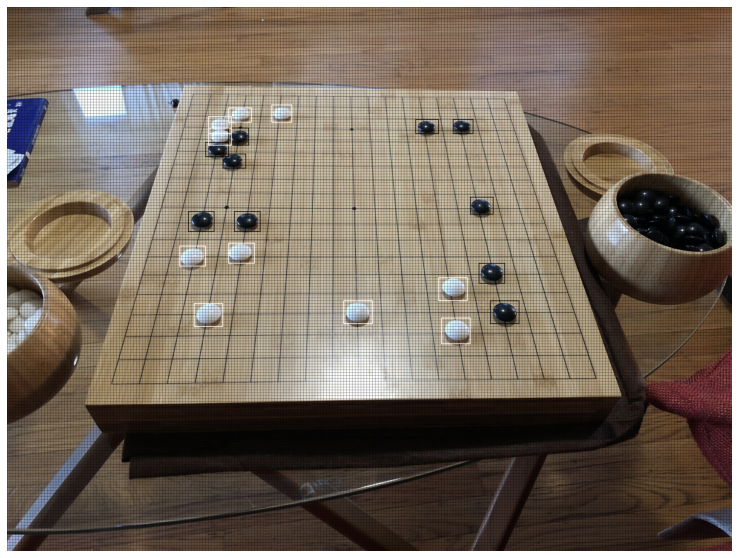

1280 720 skipping


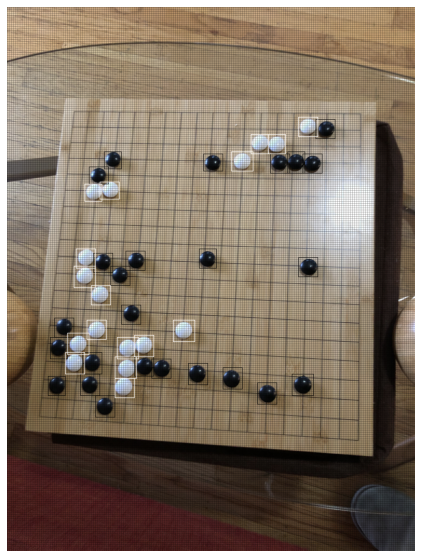

In [47]:

sizes = []
for voc_file in glob.glob('data/labelled/*.xml'):
    jpg_file = voc_file.replace('.xml', '.jpg')
    img = imread(jpg_file)
    if len(img) < 1000:
        print(len(img[0]), len(img), 'skipping')
        continue
        
    stones = [
        (stone['name'], {
            'x1': int(stone['bndbox']['xmin']),
            'y1': int(stone['bndbox']['ymin']),
            'x2': int(stone['bndbox']['xmax']),
            'y2': int(stone['bndbox']['ymax']),
        })
        for stone in XMLtoDict.parse(open(voc_file).read())['annotation']['object']
    ]

    step_size = 16
    for x in range(0, len(img[0]), step_size):
        rr, cc = skimage.draw.line(0, x, len(img)-1, x)
        # print(rr, cc)
        img[rr, cc, :] = 0

    for y in range(0, len(img), step_size):
        rr, cc = skimage.draw.line(y, 0, y, len(img[0])-1)
        img[rr, cc, :] = 0

    for stone_name, stone_box in stones:
        x1 = stone_box['x1']
        y1 = stone_box['y1']
        x2 = stone_box['x2']
        y2 = stone_box['y2']

        x1 = x1 - (x1 % step_size)
        y1 = y1 - (y1 % step_size)

        x2 = x2 + (step_size - (x2 % step_size))
        y2 = y2 + (step_size - (y2 % step_size))

        step_width = (x2-x1)/step_size
        step_height = (y2-y1)/step_size
        sizes.append({'width': step_width, 'height': step_height})

        for border in range(0,4):
            rr, cc = skimage.draw.rectangle_perimeter(start=(y1+border, x1+border), end=(y2-border, x2-border))
            img[rr, cc, :] = (0 if stone_name == 'stone_1' else 255)
   
    fig, ax = plt.subplots(figsize=(18, 10))
    ax.axis("off")
    ax.imshow(img)
    plt.show()

In [59]:
print('Dimensions frequency data')
df = pd.DataFrame(sizes).astype(int)
df['area'] = df['width'] * df['height']
df['dimensions'] = df.apply(lambda row: f"{row['width']} x {row['height']}", axis=1)
df['ratio'] = df['width'] / df['height']
df_frequencies = pd.DataFrame({'frequency':df.groupby(['area', 'dimensions', 'ratio']).size()}).reset_index().sort_values('ratio').sort_values('frequency', ascending=False)
df_frequencies

Dimensions frequency data


,area,dimensions,ratio,frequency
10,81,9 x 9,1.000000,16
12,90,9 x 10,0.900000,8
13,100,10 x 10,1.000000,6
4,63,9 x 7,1.285714,5
6,72,8 x 9,0.888889,4
8,80,10 x 8,1.250000,4
1,40,8 x 5,1.600000,4
7,72,9 x 8,1.125000,3
3,48,8 x 6,1.333333,3
9,80,8 x 10,0.800000,2


In [115]:
df_scales = pd.DataFrame([
    # {'scaled_width': 6, 'scaled_height': 7},
    {'scaled_width': 7, 'scaled_height': 7},
    # {'scaled_width': 7, 'scaled_height': 6},
    {'scaled_width': 7, 'scaled_height': 5},
])
df_scales['area'] = df_scales['scaled_width'] * df_scales['scaled_height']
df_scales['scaled_dimensions'] = df_scales.apply(lambda row: f"{row['scaled_width']} x {row['scaled_height']}", axis=1)
df_scales['scaled_ratio'] = df_scales['scaled_width'] / df_scales['scaled_height']
# df_scales.set_index('scaled_ratio', inplace=True)
df_scales


,scaled_width,scaled_height,area,scaled_dimensions,scaled_ratio
0,7,7,49,7 x 7,1.0
1,7,5,35,7 x 5,1.4


In [116]:
df_frequencies['scale_ratio_closest_match'] = df_frequencies['ratio'].map(lambda ratio: df_scales.iloc[(df_scales['scaled_ratio'] - ratio).abs().idxmin()]['scaled_ratio'])
df_scale_pairings = df_scales.drop(columns={'area'}).merge(df_frequencies.drop(columns={'area'}), left_on='scaled_ratio', right_on='scale_ratio_closest_match')

df_scale_pairings = df_scale_pairings[['dimensions', 'ratio', 'scaled_dimensions', 'scaled_ratio', 'frequency']]
df_scale_pairings['percentage_of_scaled_ratio'] = (100*df_scale_pairings['ratio'] / df_scale_pairings['scaled_ratio']).astype(int)
df_scale_pairings['percentage_ratio_loss'] = (100 - df_scale_pairings['percentage_of_scaled_ratio']).abs()
df_scale_pairings['aggegrate_percentage_ratio_loss'] = df_scale_pairings['percentage_ratio_loss'] * df_scale_pairings['frequency']

df_scale_pairings.sort_values('aggegrate_percentage_ratio_loss', ascending=False).set_index(['dimensions', 'ratio', 'scaled_dimensions', 'scaled_ratio'])


,,,,frequency,percentage_of_scaled_ratio,percentage_ratio_loss,aggegrate_percentage_ratio_loss
dimensions,ratio,scaled_dimensions,scaled_ratio,,,,
9 x 10,0.900000,7 x 7,1.0,8,90,10,80
8 x 5,1.600000,7 x 5,1.4,4,114,14,56
8 x 9,0.888889,7 x 7,1.0,4,88,12,48
9 x 7,1.285714,7 x 5,1.4,5,91,9,45
10 x 8,1.250000,7 x 5,1.4,4,89,11,44
8 x 10,0.800000,7 x 7,1.0,2,80,20,40
9 x 8,1.125000,7 x 7,1.0,3,112,12,36
7 x 6,1.166667,7 x 7,1.0,2,116,16,32
10 x 9,1.111111,7 x 7,1.0,2,111,11,22


In [95]:
ratio = 1.5


0